In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from acquire import get_zillow_data
from env import get_connection
import os 
from sklearn.model_selection import train_test_split
from wrangle import wrangle_zillow
from scipy import stats
import sklearn.preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
import wrangle


In [2]:
df = get_zillow_data()

In [3]:
df.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
0,0.0,0.0,NaN,27516.0,NaN,NaN,6037.0
1,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
2,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
3,0.0,0.0,NaN,2108.0,NaN,174.21,6037.0
4,4.0,2.0,3633.0,296425.0,2005.0,6941.39,6037.0


In [4]:
train, validate, test = wrangle_zillow()

In [5]:
train.shape, validate.shape, test.shape

((1192919, 7), (511252, 7), (426043, 7))

In [7]:
train.head()

,bedrooms,bathrooms,square_feet,tax_value,year_built,tax_amount,fips
553191,4,2.0,1556,373090,1923,4579.25,6037
1209132,3,2.0,1513,74070,1937,986.55,6037
174634,4,2.0,2040,138000,1954,2553.05,6037
170584,3,2.0,1834,263870,1959,3139.76,6059
2001226,2,2.0,1225,335603,1975,3461.38,6059


In [8]:
train_scaled = train.copy()
validate_scaled = validate.copy()
test_scaled = test.copy()
scale_cols=['bedrooms', 'bathrooms', 'tax_amount', 'square_feet']

In [10]:
mm_scaler = sklearn.preprocessing.MinMaxScaler()
# Note that we only call .fit with the training data,
# but we use .transform to apply the scaling to all the data splits.
mm_scaler.fit(train[scale_cols])

train_scaled[scale_cols] = pd.DataFrame(mm_scaler.transform(train[scale_cols]),
                              columns=train[scale_cols].columns.values).set_index([train.index.values])
validate_scaled[scale_cols] = pd.DataFrame(mm_scaler.transform(validate[scale_cols]),
                                 columns=validate[scale_cols].columns.values).set_index([validate.index.values])
test_scaled[scale_cols] = pd.DataFrame(mm_scaler.transform(test[scale_cols]),
                             columns=test[scale_cols].columns.values).set_index([test.index.values])


In [13]:
train.columns

Index(['bedrooms', 'bathrooms', 'square_feet', 'tax_value', 'year_built',
       'tax_amount', 'fips'],
      dtype='object')

In [15]:
train_scaled.head(2)

,bedrooms,bathrooms,square_feet,tax_value,year_built,tax_amount,fips
553191,0.16,0.1,0.002928,373090,1923,0.004593,6037
1209132,0.12,0.1,0.002847,74070,1937,0.000979,6037


Text(0, 0.5, 'Count')

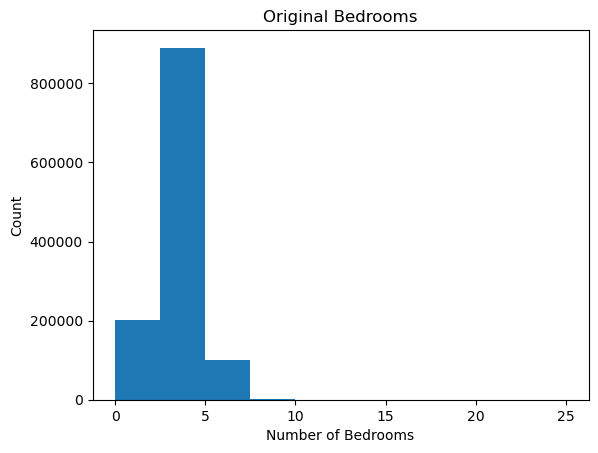

In [17]:
plt.hist(train.bedrooms)
plt.title('Original Bedrooms')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

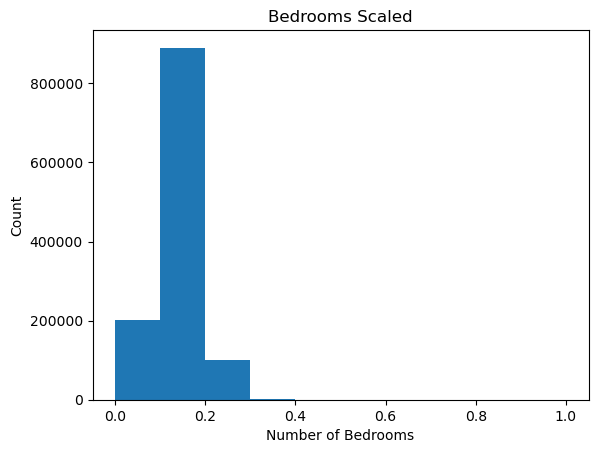

In [18]:
plt.hist(train_scaled.bedrooms)
plt.title('Bedrooms Scaled')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Count')

In [19]:
def visualize_scaler(scaler, df, scale_cols, bins=10):
    fig, axs = plt.subplots(len(scale_cols), 2, figsize=(16,9))
    df_scaled = df.copy()
    df_scaled[scale_cols] = scaler.fit_transform(df[scale_cols])
    for (ax1, ax2), col in zip(axs, scale_cols):
        ax1.hist(df[col], bins=bins)
        ax1.set(title=f'{col} before scaling', xlabel=col, ylabel='count')
        ax2.hist(df_scaled[col], bins=bins)
        ax2.set(title=f'{col} after scaling with {scaler.__class__.__name__}', xlabel=col, ylabel='count')
    plt.tight_layout()
#    return fig, axs

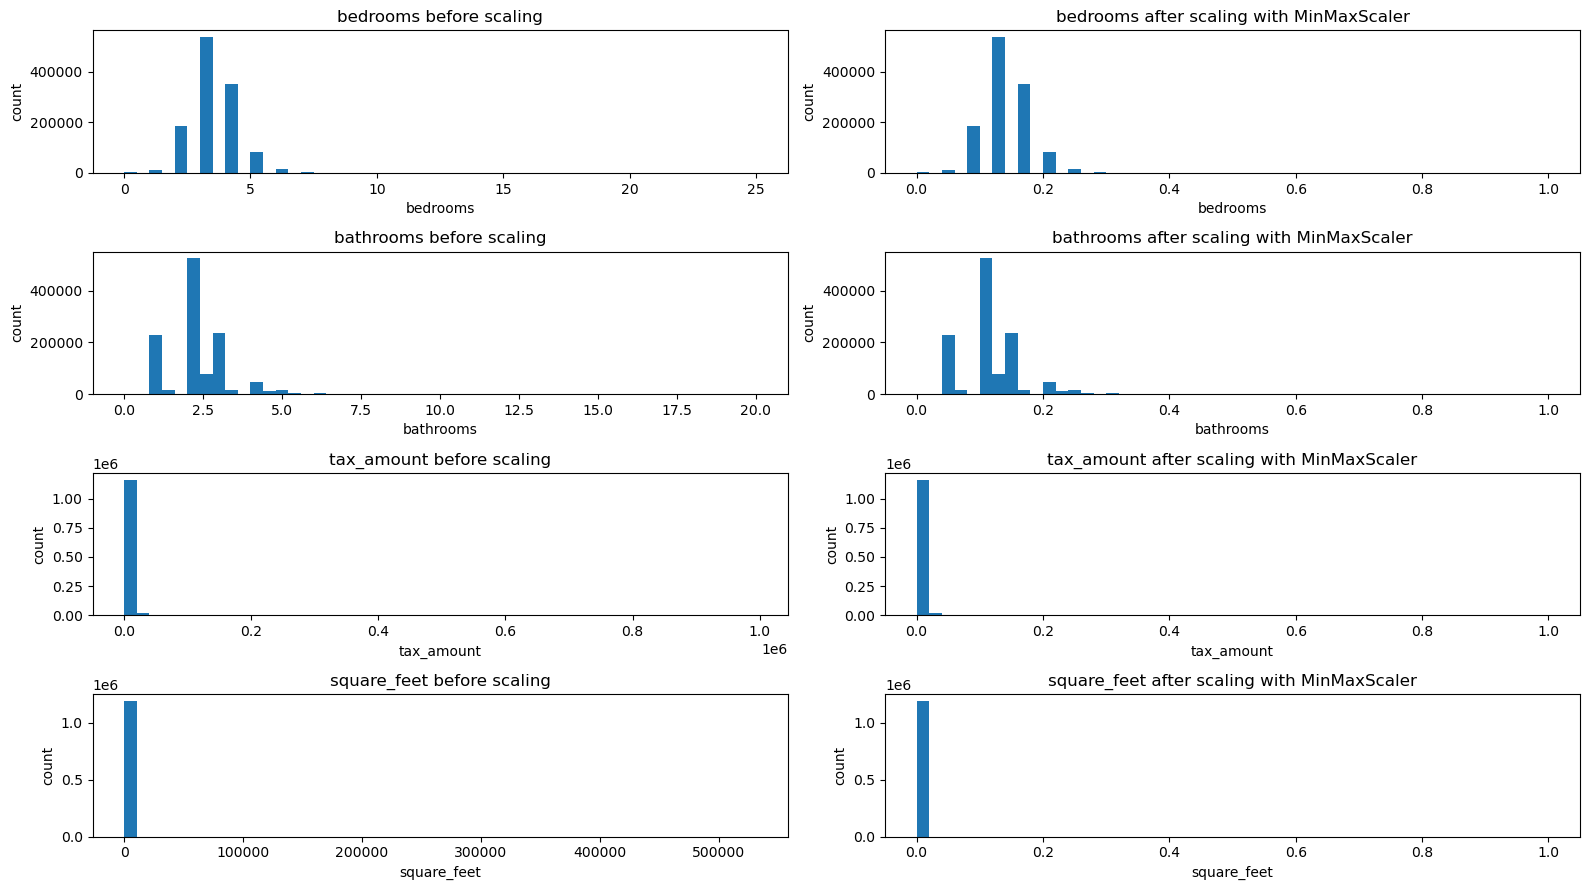

In [20]:
# MinMaxScaler Applied
visualize_scaler(scaler=MinMaxScaler(), 
                 df=train, 
                 scale_cols=scale_cols, 
                 bins=50)

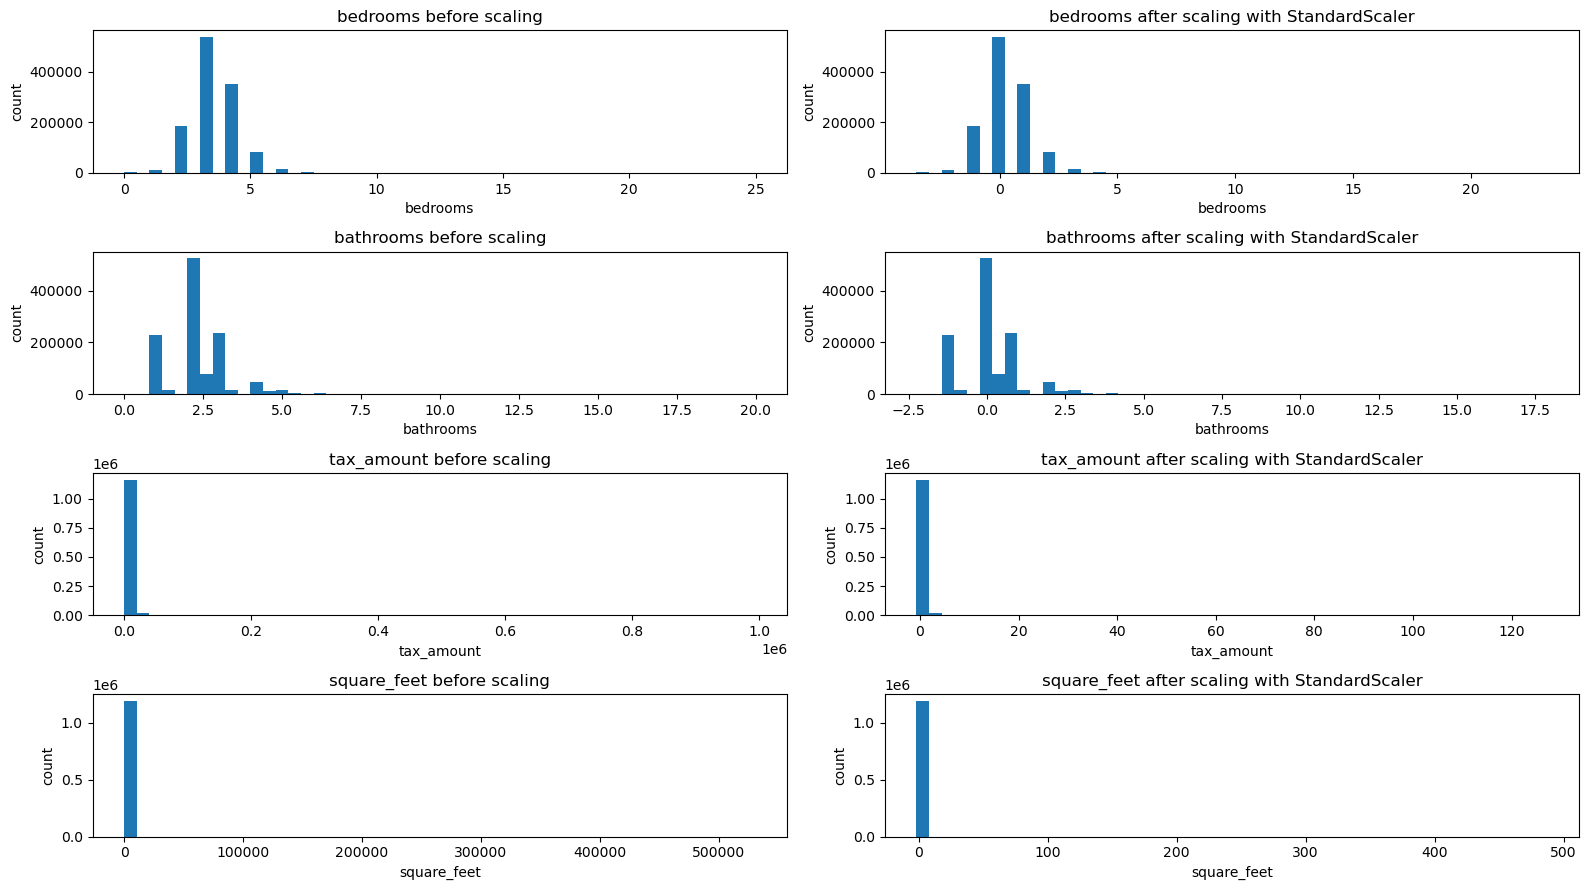

In [21]:
visualize_scaler(scaler=StandardScaler(), 
                 df=train, 
                 scale_cols=scale_cols, 
                 bins=50)

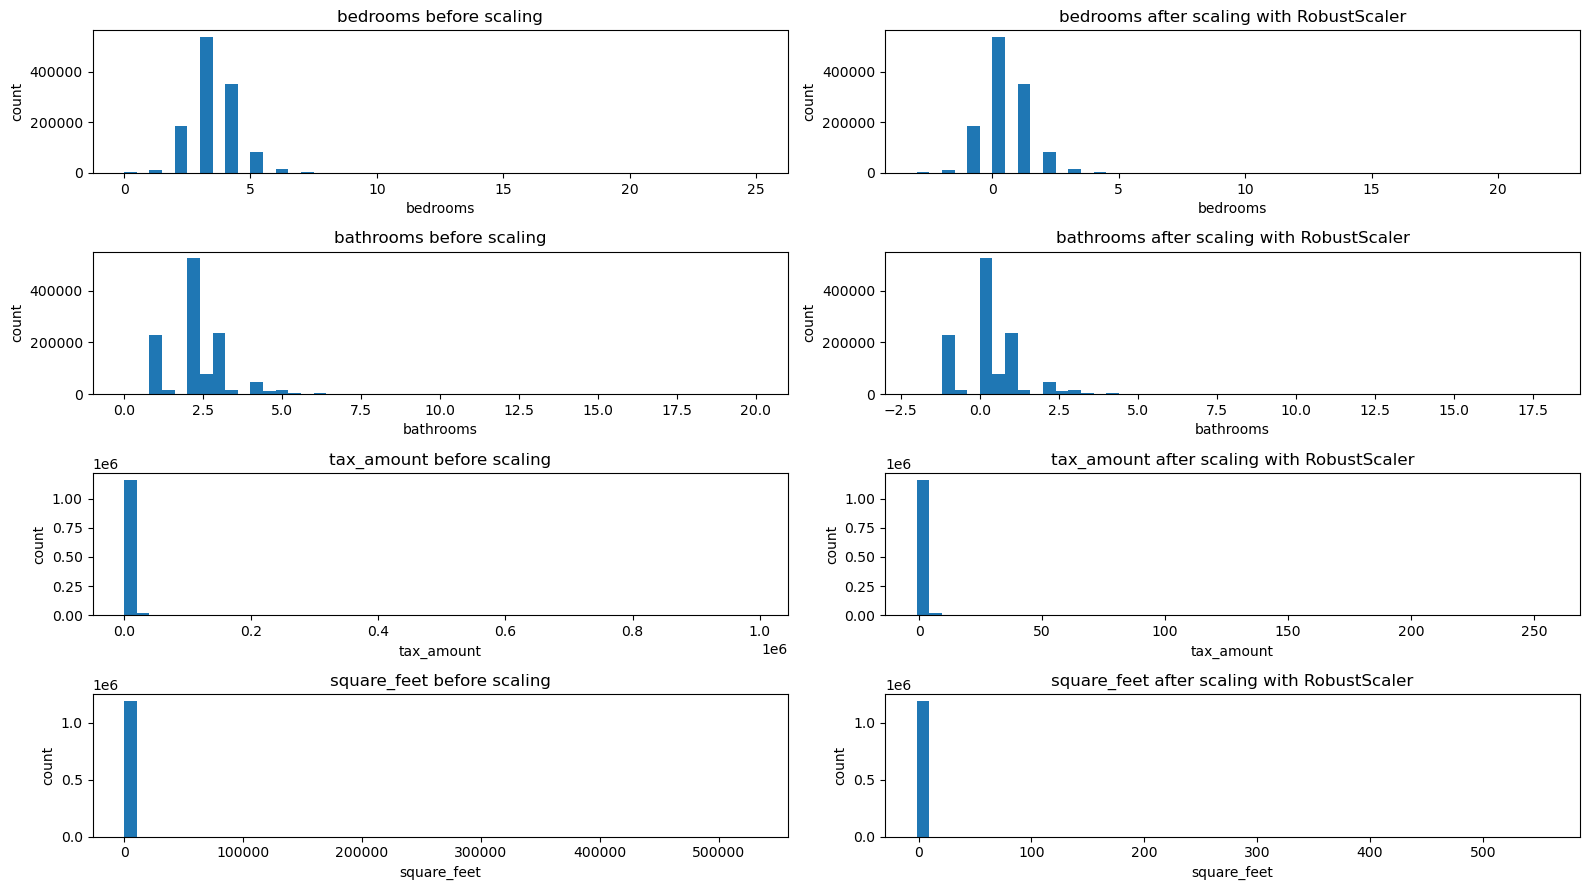

In [23]:
visualize_scaler(scaler=RobustScaler(), 
                 df=train, scale_cols=scale_cols, 
                 bins=50)

In [25]:
mm_scaler = MinMaxScaler()
original_data = train[['tax_amount']]
scaled_data = mm_scaler.fit_transform(original_data)

In [26]:
scaled_data[:5]

array([[0.00459337],
       [0.00097905],
       [0.00255497],
       [0.00314522],
       [0.00346877]])

In [27]:
original_data[:5]

,tax_amount
553191,4579.25
1209132,986.55
174634,2553.05
170584,3139.76
2001226,3461.38


In [28]:
mm_scaler.inverse_transform(scaled_data)[:5]

array([[4579.25],
       [ 986.55],
       [2553.05],
       [3139.76],
       [3461.38]])

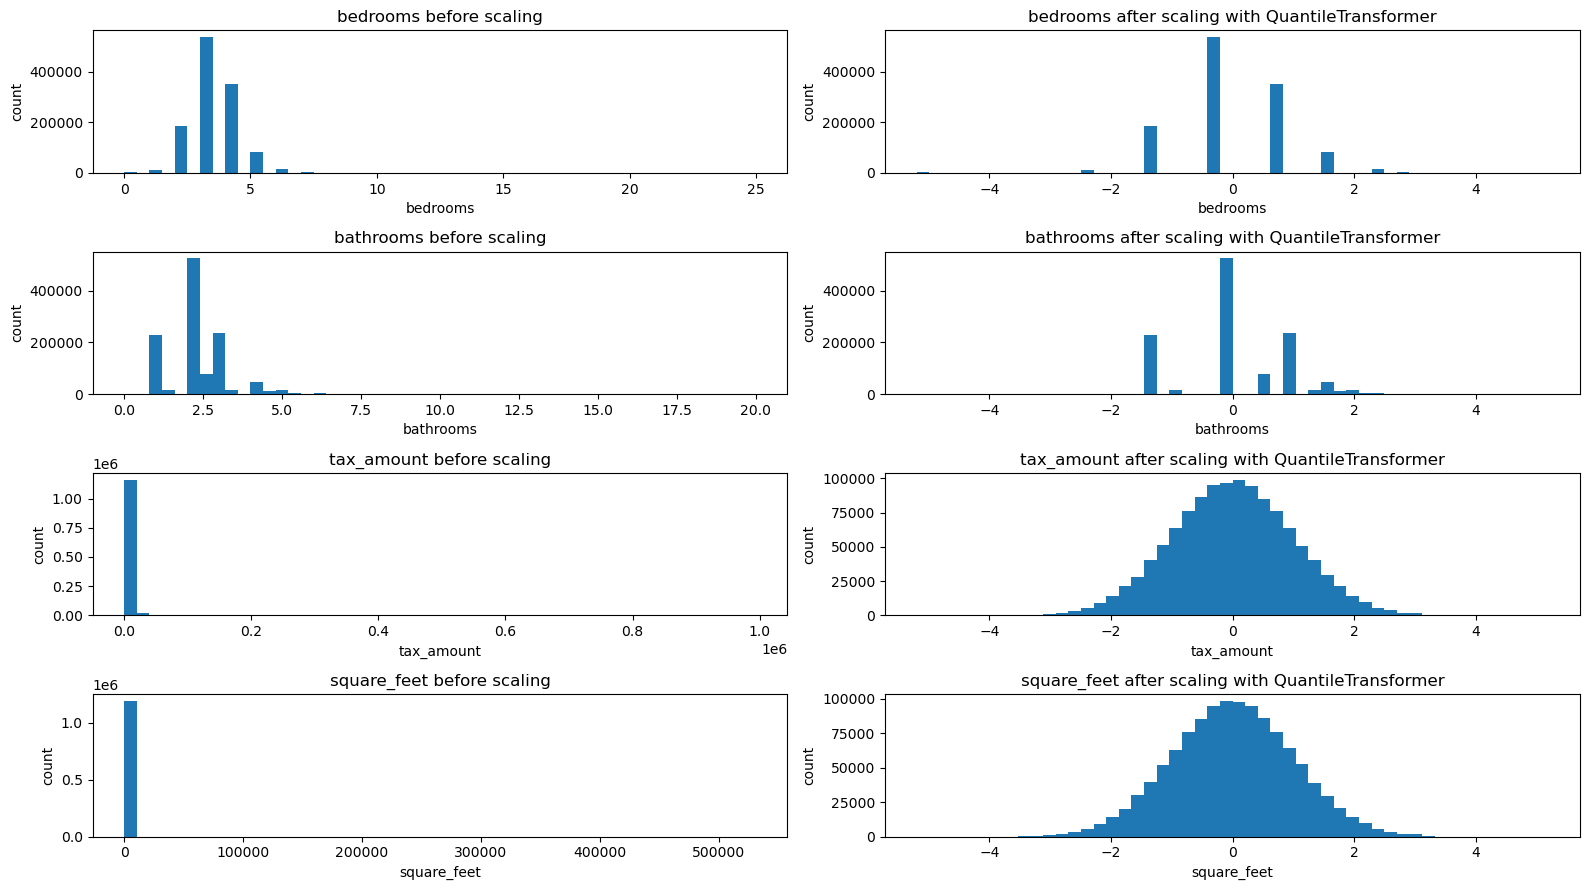

In [32]:
visualize_scaler(scaler=QuantileTransformer(output_distribution='normal'), 
                 df=train,
                 scale_cols=scale_cols, 
                 bins=50)

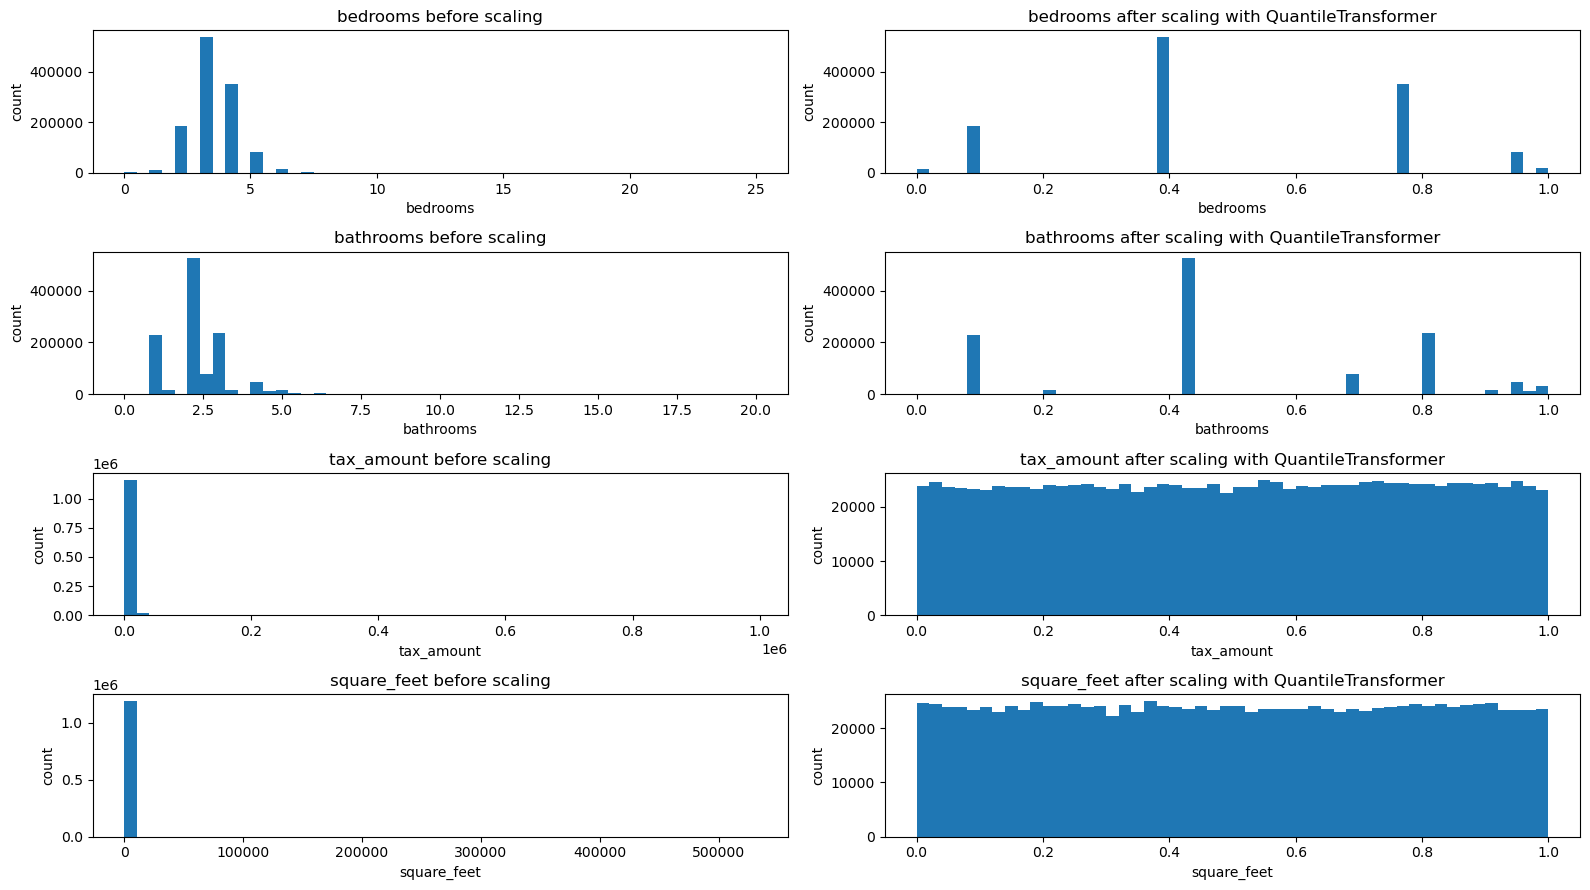

In [36]:
visualize_scaler(scaler=QuantileTransformer(), df=train, scale_cols=scale_cols, bins=50)

In [41]:
def scale_data(train, 
               validate, 
               test, 
               scale_cols=['bedrooms', 'bathrooms', 'tax_amount', 'sq_feet'],
               return_scaler=False):
    '''
    Scales the 3 data splits. 
    Takes in train, validate, and test data splits and returns them scaled.
    If return_scalar is True, the scaler object will be returned as well
    '''
    # make copies of the original data so no leakage
    train_scaled = train.copy()
    validate_scaled = validate.copy()
    test_scaled = test.copy()
    # variable 
    mm_scaler = MinMaxScaler()
    # fit it to scaler
    mm_scaler.fit(train[columns_to_scale])
    # scaling train, validate, test, and columns
    train_scaled[columns_to_scale] = pd.DataFrame(scaler.transform(train[columns_to_scale]),
                                                  columns=train[columns_to_scale].columns.values).set_index([train.index.values])
                                                  
    validate_scaled[columns_to_scale] = pd.DataFrame(scaler.transform(validate[columns_to_scale]),
                                                  columns=validate[columns_to_scale].columns.values).set_index([validate.index.values])
    
    test_scaled[columns_to_scale] = pd.DataFrame(scaler.transform(test[columns_to_scale]),
                                                 columns=test[columns_to_scale].columns.values).set_index([test.index.values])
    
    if return_scaler:
        return mm_scaler, train_scaled, validate_scaled, test_scaled
    else:
        return train_scaled, validate_scaled, test_scaled

In [42]:
mm_scaler

MinMaxScaler()

In [43]:
train_scaled.head()

,bedrooms,bathrooms,square_feet,tax_value,year_built,tax_amount,fips
553191,0.16,0.1,0.002928,373090,1923,0.004593,6037
1209132,0.12,0.1,0.002847,74070,1937,0.000979,6037
174634,0.16,0.1,0.003839,138000,1954,0.002555,6037
170584,0.12,0.1,0.003451,263870,1959,0.003145,6059
2001226,0.08,0.1,0.002305,335603,1975,0.003469,6059


In [44]:
validate_scaled.head()

,bedrooms,bathrooms,square_feet,tax_value,year_built,tax_amount,fips
1142262,0.16,0.10,0.003127,274650,1954,0.003361,6037
748805,0.08,0.05,0.001514,220209,1954,0.002711,6037
46010,0.16,0.20,0.007940,985296,1994,0.011175,6037
2021431,0.12,0.10,0.003387,390539,1973,0.004500,6059
915013,0.12,0.10,0.002787,407144,2003,0.004959,6037


In [45]:
test_scaled.head()

,bedrooms,bathrooms,square_feet,tax_value,year_built,tax_amount,fips
613589,0.16,0.15,0.005281,654656,2005,0.006994,6111
1500244,0.08,0.05,0.002815,193809,1914,0.002528,6037
401338,0.12,0.10,0.002412,236592,1953,0.002854,6037
1160052,0.20,0.15,0.003225,224910,1958,0.002937,6059
663330,0.16,0.10,0.003869,423227,1929,0.005346,6037
